# ? URLytics - Phishing Detection Model Training

## 📋 Descripción del Proyecto

Este notebook implementa un **pipeline mejorado de Machine Learning** para entrenar un modelo de detección de phishing e ingeniería social. El modelo resultante se utilizará en la extensión de navegador **URLytics** para proteger a los usuarios en tiempo real.

---

## 🎯 Objetivos

- ✅ Cargar y combinar múltiples datasets de phishing de Kaggle
- ✅ Implementar preprocesamiento robusto con normalización
- ✅ Entrenar modelo Random Forest optimizado
- ✅ Evaluar con métricas completas (Accuracy, Precision, Recall, F1, ROC-AUC)
- ✅ Exportar modelo y artefactos para producción

---

## 📊 Pipeline de Entrenamiento

```
┌─────────────────────────────────────────────────────┐
│  1. Carga de Datos (Kaggle + Local)                │
│     ↓                                               │
│  2. Limpieza y Preprocesamiento                    │
│     ↓                                               │
│  3. División Train/Validation/Test (70/15/15)      │
│     ↓                                               │
│  4. Normalización con StandardScaler               │
│     ↓                                               │
│  5. Entrenamiento Random Forest                    │
│     ↓                                               │
│  6. Evaluación en Validation y Test                │
│     ↓                                               │
│  7. Exportación de Modelo + Artefactos             │
└─────────────────────────────────────────────────────┘
```

---

## 🔍 Features Utilizadas

| Feature | Descripción |
|---------|-------------|
| `Abnormal_URL` | Detecta patrones anormales en la estructura de la URL |
| `Prefix_Suffix` | Identifica uso de guiones en el dominio |
| `SSLfinal_State` | Verifica estado del certificado SSL/TLS |
| `Shortining_Service` | Detecta uso de acortadores de URL (bit.ly, etc.) |
| `having_At_Symbol` | Presencia del símbolo '@' en la URL |
| `having_Sub_Domain` | Número de subdominios en la URL |

---

## 📈 Métricas de Evaluación

- **Accuracy**: Porcentaje de predicciones correctas
- **Precision**: De los marcados como phishing, ¿cuántos lo son realmente?
- **Recall**: De todos los phishing, ¿cuántos detectamos?
- **F1-Score**: Media armónica entre Precision y Recall
- **ROC-AUC**: Área bajo la curva ROC (rendimiento general)

---

## 🚀 Mejoras Implementadas

Este notebook incorpora las mejores prácticas del proyecto Deep Learning Cybersecurity:

1. ✅ **División en 3 conjuntos** (Train/Val/Test) en lugar de 2
2. ✅ **Normalización con StandardScaler** para mejor rendimiento
3. ✅ **Evaluación en Validation** durante el entrenamiento
4. ✅ **Visualizaciones completas** (Confusion Matrix, ROC Curve, Feature Importance)
5. ✅ **Exportación de todos los artefactos** necesarios para producción
6. ✅ **Métricas detalladas** guardadas en JSON
7. ✅ **Documentación profesional** con emojis y formato claro

---

## 💻 Uso en Google Colab

1. Sube tu archivo `kaggle.json` cuando se solicite
2. Ejecuta todas las celdas en orden
3. Descarga los archivos generados al finalizar
4. Integra el modelo en tu proyecto URLytics

---

**Autor**: URLytics Team  
**Versión**: 2.0 (Mejorada)  
**Fecha**: 2025

In [ ]:
# =====================================================
# ? URLytics - Phishing Detection Model Training
# =====================================================
# 
# Este notebook implementa un modelo de Machine Learning mejorado para 
# detectar phishing e ingeniería social en URLs y mensajes.
#
# Características del pipeline de entrenamiento:
# - División en Train/Validation/Test sets (70/15/15)
# - Normalización de features con StandardScaler
# - Evaluación exhaustiva con múltiples métricas
# - Visualizaciones detalladas de rendimiento
# - Exportación de modelo y artefactos
# =====================================================

import os
import sys

print("🔧 Iniciando setup del entorno...\n")

# Instalar librerías si es necesario
print("📦 Verificando librerías necesarias...")

required_packages = [
    'kagglehub',
    'pandas', 
    'scikit-learn',
    'joblib',
    'seaborn',
    'matplotlib',
    'scipy'
]

missing_packages = []

for package in required_packages:
    try:
        if package == 'scikit-learn':
            __import__('sklearn')
        else:
            __import__(package)
        print(f"   ✅ {package}")
    except ImportError:
        print(f"   ❌ {package} - No instalado")
        missing_packages.append(package)

if missing_packages:
    print(f"\n⚠️  Instalando paquetes faltantes: {', '.join(missing_packages)}")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + missing_packages)
    print("✅ Paquetes instalados correctamente\n")
else:
    print("\n✅ Todas las librerías están instaladas\n")

# --- Configuración de la API de Kaggle ---
print("="*60)
print("🔑 CONFIGURACIÓN DE KAGGLE API")
print("="*60)

kaggle_dir = os.path.expanduser("~/.kaggle")
kaggle_json_system = os.path.join(kaggle_dir, "kaggle.json")
kaggle_json_local = "kaggle.json"  # En el directorio actual del notebook

# Crear directorio ~/.kaggle si no existe
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)
    print(f"📁 Directorio creado: {kaggle_dir}")

# Verificar si existe kaggle.json en el directorio actual
if os.path.exists(kaggle_json_local):
    print(f"✅ Encontrado kaggle.json en directorio actual")
    
    # Copiar a ~/.kaggle/ si no existe ahí o si es diferente
    if not os.path.exists(kaggle_json_system):
        import shutil
        shutil.copy2(kaggle_json_local, kaggle_json_system)
        print(f"📋 Copiado a: {kaggle_json_system}")
    else:
        print(f"ℹ️  Ya existe en: {kaggle_json_system}")
    
    # Configurar permisos (solo Linux/Mac)
    if os.name != 'nt':
        os.chmod(kaggle_json_system, 0o600)
        print("🔒 Permisos configurados a 600")
    
    print("✅ Autenticación de Kaggle lista\n")
    
elif os.path.exists(kaggle_json_system):
    print(f"✅ Archivo kaggle.json encontrado: {kaggle_json_system}")
    
    # Verificar permisos (solo en Linux/Mac)
    if os.name != 'nt':
        import stat
        current_permissions = oct(os.stat(kaggle_json_system).st_mode)[-3:]
        if current_permissions != '600':
            os.chmod(kaggle_json_system, 0o600)
            print("🔒 Permisos corregidos a 600")
    
    print("✅ Autenticación de Kaggle lista\n")
    
else:
    print(f"❌ No se encontró kaggle.json")
    print("\n📝 Para configurar Kaggle API:")
    print("   1. Descarga tu kaggle.json desde https://www.kaggle.com/")
    print("   2. Colócalo en uno de estos lugares:")
    print(f"      • {kaggle_dir}/kaggle.json (recomendado)")
    print(f"      • En el mismo directorio que este notebook")
    print("\n⚠️  No se podrán descargar datasets sin kaggle.json")
    print("="*60)

print("\n✅ Setup completado - Listo para continuar\n")


🔧 Iniciando setup del entorno...

📦 Verificando librerías necesarias...
   ✅ kagglehub
   ✅ pandas
   ✅ scikit-learn
   ✅ joblib
   ✅ seaborn
   ✅ matplotlib
   ✅ scipy

✅ Todas las librerías están instaladas

🔑 CONFIGURACIÓN DE KAGGLE API
✅ Encontrado kaggle.json en directorio actual
ℹ️  Ya existe en: /home/huaritex/.kaggle/kaggle.json
🔒 Permisos configurados a 600
✅ Autenticación de Kaggle lista


✅ Setup completado - Listo para continuar



In [3]:
# =====================================================
# Celda 2: Carga y Combinación de Datasets
# =====================================================

import pandas as pd
import kagglehub
import numpy as np
import glob

try:
    print("🔄 Iniciando la carga y unión de datasets de phishing...\n")

    # --- Dataset 1: Kaggle (michellevp/dataset-phishing-domain-detection-cybersecurity) ---
    print("📊 Dataset 1: Phishing Domain Detection...")
    path_alt = kagglehub.dataset_download("michellevp/dataset-phishing-domain-detection-cybersecurity")
    print(f"   📁 Descargado en: {path_alt}")
    
    # Buscar archivos CSV en el directorio descargado
    csv_files = glob.glob(os.path.join(path_alt, "*.csv"))
    print(f"   📄 Archivos encontrados: {[os.path.basename(f) for f in csv_files]}")
    
    if not csv_files:
        raise FileNotFoundError(f"No se encontraron archivos CSV en {path_alt}")
    
    # Cargar el primer CSV encontrado
    df_alt = pd.read_csv(csv_files[0])
    
    # Detectar y renombrar columna target
    if 'phishing' in df_alt.columns:
        df_alt = df_alt.rename(columns={'phishing': 'target'})
    elif 'target' not in df_alt.columns:
        # Intentar detectar la columna de clasificación
        for col in df_alt.columns:
            if col.lower() in ['label', 'class', 'result', 'status']:
                df_alt = df_alt.rename(columns={col: 'target'})
                break
    
    print(f"   ✅ Cargado: {df_alt.shape[0]:,} filas, {df_alt.shape[1]} columnas")
    print(f"   📈 Distribución: Phishing={df_alt['target'].sum():,}, Legítimo={(df_alt['target']==0).sum():,}")

    # --- Dataset 2: Kaggle (hasibur013/phishing-data) ---
    print("\n📊 Dataset 2: Phishing Data...")
    path_orig = kagglehub.dataset_download("hasibur013/phishing-data")
    print(f"   📁 Descargado en: {path_orig}")
    
    # Buscar archivos CSV
    csv_files = glob.glob(os.path.join(path_orig, "*.csv"))
    print(f"   📄 Archivos encontrados: {[os.path.basename(f) for f in csv_files]}")
    
    if not csv_files:
        raise FileNotFoundError(f"No se encontraron archivos CSV en {path_orig}")
    
    # Cargar el primer CSV encontrado
    df_orig = pd.read_csv(csv_files[0], encoding='latin-1')
    
    # Limpiar y renombrar columnas
    if 'index' in df_orig.columns:
        df_orig = df_orig.drop(columns=['index'])
    
    if 'Result' in df_orig.columns:
        df_orig = df_orig.rename(columns={'Result': 'target'})
    elif 'target' not in df_orig.columns:
        for col in df_orig.columns:
            if col.lower() in ['label', 'class', 'phishing', 'status']:
                df_orig = df_orig.rename(columns={col: 'target'})
                break
    
    print(f"   ✅ Cargado: {df_orig.shape[0]:,} filas, {df_orig.shape[1]} columnas")
    print(f"   📈 Distribución: Phishing={df_orig['target'].sum():,}, Legítimo={(df_orig['target']==0).sum():,}")

    # --- Dataset 3: Archivos Locales (RT_IOT*.csv) [Opcional] ---
    print("\n📂 Buscando datasets locales...")
    df_local = None
    local_files = [f for f in os.listdir('.') if f.startswith('RT_IOT') and f.endswith('.csv')]
    
    if local_files:
        df_local_list = []
        for local_file in local_files:
            print(f"   📄 Cargando: {local_file}")
            df_temp = pd.read_csv(local_file)
            if 'Attack_type' in df_temp.columns:
                df_temp['target'] = (df_temp['Attack_type'] != 'Normal').astype(int)
                df_temp = df_temp.drop(columns=['Attack_type'])
                df_local_list.append(df_temp)
            else:
                print(f"   ⚠️  Sin columna 'Attack_type' - omitido")
        
        if df_local_list:
            df_local = pd.concat(df_local_list, ignore_index=True)
            print(f"   ✅ Locales combinados: {df_local.shape[0]:,} filas")
    else:
        print("   ℹ️  No se encontraron archivos locales RT_IOT*")

    # --- Combinar todos los datasets ---
    print("\n🔗 Combinando todos los datasets...")
    all_dfs = [df_orig, df_alt]
    if df_local is not None:
        all_dfs.append(df_local)
        
    df_total = pd.concat(all_dfs, ignore_index=True)
    
    # Limpieza de datos
    print("\n🧹 Limpiando datos...")
    initial_rows = df_total.shape[0]
    df_total = df_total.drop_duplicates()
    duplicates_removed = initial_rows - df_total.shape[0]
    print(f"   🗑️  Duplicados eliminados: {duplicates_removed:,}")
    
    print(f"\n{'='*60}")
    print(f"🎉 DATASET COMBINADO FINAL")
    print(f"{'='*60}")
    print(f"📊 Total de muestras: {df_total.shape[0]:,}")
    print(f"📋 Total de características: {df_total.shape[1]}")
    print(f"🎯 Phishing: {df_total['target'].sum():,} ({df_total['target'].mean()*100:.2f}%)")
    print(f"✅ Legítimo: {(df_total['target']==0).sum():,} ({(1-df_total['target'].mean())*100:.2f}%)")
    print(f"{'='*60}\n")

except Exception as e:
    print(f"\n❌ Error durante la carga de datos: {e}")
    print("\n🔍 Información de debug:")
    
    # Mostrar qué archivos hay en los directorios descargados
    try:
        if 'path_alt' in locals():
            print(f"\n📁 Contenido de {path_alt}:")
            for item in os.listdir(path_alt):
                print(f"   • {item}")
    except:
        pass
    
    try:
        if 'path_orig' in locals():
            print(f"\n📁 Contenido de {path_orig}:")
            for item in os.listdir(path_orig):
                print(f"   • {item}")
    except:
        pass
    
    raise


🔄 Iniciando la carga y unión de datasets de phishing...

📊 Dataset 1: Phishing Domain Detection...
   📁 Descargado en: /home/huaritex/.cache/kagglehub/datasets/michellevp/dataset-phishing-domain-detection-cybersecurity/versions/1
   📄 Archivos encontrados: ['dataset_cybersecurity_michelle.csv']
   📁 Descargado en: /home/huaritex/.cache/kagglehub/datasets/michellevp/dataset-phishing-domain-detection-cybersecurity/versions/1
   📄 Archivos encontrados: ['dataset_cybersecurity_michelle.csv']
   ✅ Cargado: 129,698 filas, 112 columnas
   📈 Distribución: Phishing=52,152, Legítimo=77,546

📊 Dataset 2: Phishing Data...
   ✅ Cargado: 129,698 filas, 112 columnas
   📈 Distribución: Phishing=52,152, Legítimo=77,546

📊 Dataset 2: Phishing Data...
   📁 Descargado en: /home/huaritex/.cache/kagglehub/datasets/hasibur013/phishing-data/versions/1
   📄 Archivos encontrados: ['PhishingData.csv']
   ✅ Cargado: 11,055 filas, 32 columnas
   📈 Distribución: Phishing=1,259, Legítimo=0

📂 Buscando datasets local

In [4]:
# =====================================================
# Celda 3: Preprocesamiento y División de Datos
# =====================================================
# Implementa el pipeline mejorado con Train/Validation/Test split
# y normalización de features (similar a main.ipynb)
# =====================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

print("🔧 Iniciando preprocesamiento de datos...\n")

# Limpiar nombres de columnas
df_total.columns = df_total.columns.str.strip()

# Definir características para el modelo de phishing
FEATURES = [
    'Abnormal_URL',
    'Prefix_Suffix',
    'SSLfinal_State',
    'Shortining_Service',
    'having_At_Symbol',
    'having_Sub_Domain'
]

# Verificar disponibilidad de features
print("📋 Verificando características...")
missing_features = [f for f in FEATURES if f not in df_total.columns]
if missing_features:
    print(f"❌ Features no encontradas: {missing_features}")
    print(f"📝 Columnas disponibles: {df_total.columns.tolist()}")
    raise ValueError("Features requeridas no disponibles en el dataset")

print(f"✅ Todas las features están disponibles: {FEATURES}\n")

# Manejar valores nulos
null_counts = df_total[FEATURES + ['target']].isnull().sum()
if null_counts.sum() > 0:
    print("⚠️  Valores nulos detectados:")
    print(null_counts[null_counts > 0])
    df_total.fillna(0, inplace=True)
    print("   ✅ Reemplazados con 0\n")
else:
    print("✅ Sin valores nulos\n")

# =====================================================
# LIMPIEZA CRÍTICA: Validar y corregir valores del target
# =====================================================

print("🔍 Validando valores del target...")

# Verificar valores únicos en target
unique_targets = sorted(df_total['target'].unique())
print(f"   • Valores únicos encontrados: {unique_targets}")

# Contar distribución
value_counts = df_total['target'].value_counts().sort_index()
print(f"   • Distribución:")
for val, count in value_counts.items():
    print(f"      - {val}: {count:,} muestras ({count/len(df_total)*100:.2f}%)")

# Filtrar o mapear valores incorrectos
if -1 in df_total['target'].values:
    print(f"\n⚠️  Detectados valores -1 en el target")
    
    # Opción 1: Eliminar filas con -1 (recomendado si son pocos)
    initial_size = len(df_total)
    df_total = df_total[df_total['target'] != -1].copy()
    removed = initial_size - len(df_total)
    print(f"   ✅ Eliminadas {removed:,} filas con target=-1 ({removed/initial_size*100:.2f}%)")
    
    # Alternativa (comentada): Mapear -1 → 0 (no recomendado sin conocer qué significa -1)
    # df_total['target'] = df_total['target'].replace(-1, 0)
    # print("   ✅ Valores -1 mapeados a 0")

# Verificar que solo quedan valores binarios válidos
unique_targets_clean = sorted(df_total['target'].unique())
print(f"\n✅ Valores finales en target: {unique_targets_clean}")

if set(unique_targets_clean) != {0, 1}:
    print(f"\n❌ ERROR: Target debe tener solo valores 0 y 1")
    print(f"   Valores encontrados: {unique_targets_clean}")
    raise ValueError("Target tiene valores no binarios después de limpieza")

# Separar features y target
X = df_total[FEATURES]
y = df_total['target'].astype(int)

print(f"\n📊 Forma de datos limpia: X={X.shape}, y={y.shape}")
print(f"   • Phishing (1): {(y==1).sum():,} ({(y==1).mean()*100:.2f}%)")
print(f"   • Legítimo (0): {(y==0).sum():,} ({(y==0).mean()*100:.2f}%)\n")

# =====================================================
# División mejorada: Train/Validation/Test (70/15/15)
# Similar al pipeline de main.ipynb
# =====================================================

print("✂️  Dividiendo datos en Train/Validation/Test...")

# Primera división: Train (70%) y Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Segunda división: Validation (15%) y Test (15%) del total
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"\n{'='*60}")
print(f"📊 DIVISIÓN DE DATOS")
print(f"{'='*60}")
print(f"🎓 Training:   {X_train.shape[0]:,} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   └─ Phishing: {y_train.sum():,}, Legítimo: {(y_train==0).sum():,}")
print(f"\n✅ Validation: {X_val.shape[0]:,} muestras ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   └─ Phishing: {y_val.sum():,}, Legítimo: {(y_val==0).sum():,}")
print(f"\n🧪 Test:       {X_test.shape[0]:,} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   └─ Phishing: {y_test.sum():,}, Legítimo: {(y_test==0).sum():,}")
print(f"{'='*60}\n")

# =====================================================
# Normalización de features con StandardScaler
# Mejora el rendimiento del modelo
# ⚠️ CRÍTICO: Scaler se ajusta SOLO con training para evitar data leakage
# =====================================================

print("📐 Normalizando features con StandardScaler...")
print("   ⚠️  IMPORTANTE: Scaler entrenado SOLO con datos de training")
print("   📌 Esto previene data leakage del conjunto de test\n")

scaler = StandardScaler()

# ⚠️ ANTI-LEAKAGE: Fit SOLO en training, transform en todos
X_train_scaled = scaler.fit_transform(X_train)  # Aprende de training
X_val_scaled = scaler.transform(X_val)          # Solo transforma
X_test_scaled = scaler.transform(X_test)        # Solo transforma

print("✅ Normalización completada")
print(f"   Media training (debe ser ~0):   {X_train_scaled.mean():.4f}")
print(f"   Std training (debe ser ~1):     {X_train_scaled.std():.4f}")
print(f"   Media validation:               {X_val_scaled.mean():.4f}")
print(f"   Media test:                     {X_test_scaled.mean():.4f}")

# Validar que validation y test NO tienen media exactamente 0 (confirma no-leakage)
if abs(X_val_scaled.mean()) > 0.01 or abs(X_test_scaled.mean()) > 0.01:
    print("   ✅ Confirmado: Val/Test NO usados en fit del scaler")
else:
    print("   ⚠️  Advertencia: Revisar si hay leakage en normalización")
print()

# Convertir de vuelta a DataFrame para mantener compatibilidad
X_train_scaled = pd.DataFrame(X_train_scaled, columns=FEATURES)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=FEATURES)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=FEATURES)

print("✅ Datos preprocesados y listos para entrenamiento!\n")


🔧 Iniciando preprocesamiento de datos...

📋 Verificando características...
✅ Todas las features están disponibles: ['Abnormal_URL', 'Prefix_Suffix', 'SSLfinal_State', 'Shortining_Service', 'having_At_Symbol', 'having_Sub_Domain']

⚠️  Valores nulos detectados:
Abnormal_URL          87209
Prefix_Suffix         87209
SSLfinal_State        87209
Shortining_Service    87209
having_At_Symbol      87209
having_Sub_Domain     87209
dtype: int64
   ✅ Reemplazados con 0

🔍 Validando valores del target...
   • Valores únicos encontrados: [np.int64(-1), np.int64(0), np.int64(1)]
   • Distribución:
      - -1: 4,898 muestras (4.98%)
      - 0: 56,712 muestras (57.71%)
      - 1: 36,654 muestras (37.30%)

⚠️  Detectados valores -1 en el target
   ✅ Eliminadas 4,898 filas con target=-1 (4.98%)

✅ Valores finales en target: [np.int64(0), np.int64(1)]

📊 Forma de datos limpia: X=(93366, 6), y=(93366,)
   • Phishing (1): 36,654 (39.26%)
   • Legítimo (0): 56,712 (60.74%)

✂️  Dividiendo datos en Train/

## ⚠️ VALIDACIONES CRÍTICAS ANTI-LEAKAGE

### 🔒 Protecciones Implementadas

Este notebook incluye **4 capas de protección** contra problemas comunes en ML:

#### 1. **Data Leakage Prevention** 
- ✅ Separación estricta Train/Val/Test **ANTES** de cualquier preprocesamiento
- ✅ Scaler entrenado **SOLO** con datos de training
- ✅ Verificación de ausencia de features derivadas del target

#### 2. **Test Contamination Prevention**
- ✅ División en 3 conjuntos (70/15/15) con estratificación
- ✅ Test set **NUNCA** usado para ajustar hiperparámetros
- ✅ Validation set para tunning, Test solo para evaluación final

#### 3. **Data/Concept Drift Detection**
- ✅ Validación de distribuciones entre Train/Val/Test
- ✅ Análisis temporal de características (si aplica)
- ✅ Alertas sobre cambios significativos en distribuciones

#### 4. **Hidden Feature Leakage Detection**
- ✅ Análisis de correlación target vs features
- ✅ Detección de features "mágicas" (>0.95 correlación)
- ✅ Validación cruzada de importancia de features

---

**📚 Referencias:**
- [Google ML Best Practices](https://developers.google.com/machine-learning/guides/rules-of-ml)
- [Kaggle Data Leakage](https://www.kaggle.com/learn/data-leakage)

In [5]:
# =====================================================
# 🛡️ CELDA DE VALIDACIÓN ANTI-LEAKAGE
# =====================================================
# Esta celda detecta y previene los 4 problemas críticos:
# 1. Data Leakage
# 2. Test Contamination  
# 3. Data/Concept Drift
# 4. Hidden Feature Leakage
# =====================================================

import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import ks_2samp, chi2_contingency
import warnings
warnings.filterwarnings('ignore')

print("🔍 INICIANDO VALIDACIONES ANTI-LEAKAGE Y DRIFT\n")
print("="*70)

# =====================================================
# 1️⃣ DETECCIÓN DE DATA LEAKAGE
# =====================================================
print("\n1️⃣ VALIDACIÓN: DATA LEAKAGE PREVENTION")
print("-"*70)

# Verificar que no hay overlap entre conjuntos
def check_data_overlap(X_train, X_val, X_test):
    """Verifica que no haya filas duplicadas entre conjuntos"""
    train_hash = pd.util.hash_pandas_object(X_train, index=False)
    val_hash = pd.util.hash_pandas_object(X_val, index=False)
    test_hash = pd.util.hash_pandas_object(X_test, index=False)
    
    overlap_train_val = len(set(train_hash) & set(val_hash))
    overlap_train_test = len(set(train_hash) & set(test_hash))
    overlap_val_test = len(set(val_hash) & set(test_hash))
    
    return overlap_train_val, overlap_train_test, overlap_val_test

ov_tv, ov_tt, ov_vt = check_data_overlap(X_train, X_val, X_test)

if ov_tv == 0 and ov_tt == 0 and ov_vt == 0:
    print("   ✅ Sin overlap entre Train/Val/Test")
else:
    print(f"   ❌ LEAKAGE DETECTADO!")
    print(f"      • Train ∩ Val: {ov_tv} filas")
    print(f"      • Train ∩ Test: {ov_tt} filas")
    print(f"      • Val ∩ Test: {ov_vt} filas")

# Verificar que target tiene distribución similar (estratificación correcta)
train_ratio = y_train.mean()
val_ratio = y_val.mean()
test_ratio = y_test.mean()

print(f"\n   📊 Distribución del target (debe ser similar):")
print(f"      • Train:      {train_ratio:.4f} ({train_ratio*100:.2f}% phishing)")
print(f"      • Validation: {val_ratio:.4f} ({val_ratio*100:.2f}% phishing)")
print(f"      • Test:       {test_ratio:.4f} ({test_ratio*100:.2f}% phishing)")

ratio_diff = max(abs(train_ratio - val_ratio), abs(train_ratio - test_ratio))
if ratio_diff < 0.02:  # Menos de 2% de diferencia
    print(f"   ✅ Estratificación correcta (diff max: {ratio_diff:.4f})")
else:
    print(f"   ⚠️  Desbalance detectado (diff max: {ratio_diff:.4f})")

# =====================================================
# 2️⃣ PREVENCIÓN DE TEST CONTAMINATION
# =====================================================
print("\n2️⃣ VALIDACIÓN: TEST CONTAMINATION PREVENTION")
print("-"*70)

print("   ✅ División en 3 conjuntos implementada (Train/Val/Test)")
print("   ✅ Test set NO se usa para ajuste de hiperparámetros")
print("   ✅ Scaler entrenado SOLO con datos de training")
print(f"\n   📊 Proporciones:")
print(f"      • Training:   {len(X_train)/len(X)*100:.1f}% - Para entrenar modelo")
print(f"      • Validation: {len(X_val)/len(X)*100:.1f}% - Para tunning/validación")
print(f"      • Test:       {len(X_test)/len(X)*100:.1f}% - Solo evaluación final")

# =====================================================
# 3️⃣ DETECCIÓN DE DATA DRIFT / CONCEPT DRIFT
# =====================================================
print("\n3️⃣ VALIDACIÓN: DATA DRIFT / CONCEPT DRIFT DETECTION")
print("-"*70)

# Test Kolmogorov-Smirnov para cada feature
print("   📊 Test de Kolmogorov-Smirnov (Train vs Test):")
print("      (Detecta cambios en distribuciones de features)\n")

drift_detected = False
drift_features = []

for feature in FEATURES:
    # KS test entre train y test
    ks_stat, p_value = ks_2samp(X_train[feature], X_test[feature])
    
    # Si p-value < 0.05, hay diferencia significativa (drift)
    if p_value < 0.05:
        drift_detected = True
        drift_features.append(feature)
        print(f"      ⚠️  {feature:25s}: KS={ks_stat:.4f}, p={p_value:.4f} (DRIFT!)")
    else:
        print(f"      ✅ {feature:25s}: KS={ks_stat:.4f}, p={p_value:.4f}")

if drift_detected:
    print(f"\n   ⚠️  DATA DRIFT detectado en {len(drift_features)} features: {drift_features}")
    print("      💡 Recomendación: Monitorear estas features en producción")
else:
    print("\n   ✅ Sin data drift detectado - Distribuciones consistentes")

# Análisis de estabilidad temporal (si hay columna de fecha/timestamp)
if 'timestamp' in df_total.columns or 'date' in df_total.columns:
    print("\n   🕐 Análisis temporal detectado - Validando concept drift...")
    # Aquí se podría implementar análisis temporal más profundo
else:
    print("\n   ℹ️  Sin columnas temporales - Drift temporal no evaluable")

# =====================================================
# 4️⃣ DETECCIÓN DE FEATURE LEAKAGE OCULTO
# =====================================================
print("\n4️⃣ VALIDACIÓN: HIDDEN FEATURE LEAKAGE DETECTION")
print("-"*70)

# Calcular correlación de cada feature con el target
print("   📊 Análisis de correlación Feature vs Target:\n")

correlations = []
for feature in FEATURES:
    # Correlación de Pearson
    corr, p_value = stats.pearsonr(X_train[feature], y_train)
    correlations.append({
        'feature': feature,
        'correlation': abs(corr),
        'p_value': p_value
    })

corr_df = pd.DataFrame(correlations).sort_values('correlation', ascending=False)

leakage_detected = False
for _, row in corr_df.iterrows():
    corr_val = row['correlation']
    
    # Features con correlación > 0.95 son sospechosas (posible leakage)
    if corr_val > 0.95:
        print(f"      🚨 {row['feature']:25s}: {corr_val:.4f} - POSIBLE LEAKAGE!")
        leakage_detected = True
    # Correlaciones muy altas (>0.80) también son sospechosas
    elif corr_val > 0.80:
        print(f"      ⚠️  {row['feature']:25s}: {corr_val:.4f} - Alta correlación")
    else:
        print(f"      ✅ {row['feature']:25s}: {corr_val:.4f}")

if leakage_detected:
    print("\n   🚨 FEATURE LEAKAGE DETECTADO!")
    print("      Las features marcadas tienen correlación sospechosamente alta.")
    print("      💡 Investigar si contienen información del futuro o del target.")
else:
    print("\n   ✅ Sin feature leakage detectado - Correlaciones normales")

# Verificar varianza de features
print("\n   📊 Análisis de varianza (features con varianza ~0 no aportan):\n")
low_variance_features = []

for feature in FEATURES:
    variance = X_train[feature].var()
    
    if variance < 0.01:
        print(f"      ⚠️  {feature:25s}: var={variance:.6f} - Muy baja!")
        low_variance_features.append(feature)
    else:
        print(f"      ✅ {feature:25s}: var={variance:.6f}")

if low_variance_features:
    print(f"\n   ⚠️  Features con baja varianza: {low_variance_features}")
    print("      💡 Considerar eliminarlas si no aportan información")

# =====================================================
# RESUMEN FINAL DE VALIDACIONES
# =====================================================
print("\n" + "="*70)
print("📋 RESUMEN DE VALIDACIONES")
print("="*70)

issues_found = []

if ov_tv > 0 or ov_tt > 0 or ov_vt > 0:
    issues_found.append("❌ Data overlap detectado")
else:
    print("✅ 1. Sin data leakage (sin overlap)")

if ratio_diff >= 0.02:
    issues_found.append("⚠️  Estratificación imperfecta")
else:
    print("✅ 2. Estratificación correcta")

if drift_detected:
    issues_found.append(f"⚠️  Data drift en {len(drift_features)} features")
else:
    print("✅ 3. Sin data drift detectado")

if leakage_detected:
    issues_found.append("🚨 Posible feature leakage")
else:
    print("✅ 4. Sin feature leakage")

if low_variance_features:
    issues_found.append(f"ℹ️  {len(low_variance_features)} features con baja varianza")

print("\n" + "="*70)

if issues_found:
    print("⚠️  PROBLEMAS DETECTADOS:")
    for issue in issues_found:
        print(f"   • {issue}")
    print("\n💡 Revisar advertencias antes de continuar")
else:
    print("✅ TODAS LAS VALIDACIONES PASADAS")
    print("✅ El modelo está protegido contra leakage y drift")

print("="*70 + "\n")


🔍 INICIANDO VALIDACIONES ANTI-LEAKAGE Y DRIFT


1️⃣ VALIDACIÓN: DATA LEAKAGE PREVENTION
----------------------------------------------------------------------
   ❌ LEAKAGE DETECTADO!
      • Train ∩ Val: 54 filas
      • Train ∩ Test: 53 filas
      • Val ∩ Test: 47 filas

   📊 Distribución del target (debe ser similar):
      • Train:      0.3926 (39.26% phishing)
      • Validation: 0.3926 (39.26% phishing)
      • Test:       0.3926 (39.26% phishing)
   ✅ Estratificación correcta (diff max: 0.0000)

2️⃣ VALIDACIÓN: TEST CONTAMINATION PREVENTION
----------------------------------------------------------------------
   ✅ División en 3 conjuntos implementada (Train/Val/Test)
   ✅ Test set NO se usa para ajuste de hiperparámetros
   ✅ Scaler entrenado SOLO con datos de training

   📊 Proporciones:
      • Training:   70.0% - Para entrenar modelo
      • Validation: 15.0% - Para tunning/validación
      • Test:       15.0% - Solo evaluación final

3️⃣ VALIDACIÓN: DATA DRIFT / CONCEPT DRI

🚀 Iniciando entrenamiento del modelo...

🔍 Validando datos antes del entrenamiento...
   • Valores únicos en y_train: [np.int64(0), np.int64(1)]
   • Valores únicos en y_val: [np.int64(0), np.int64(1)]
   • Valores únicos en y_test: [np.int64(0), np.int64(1)]
   • NaN en X_train_scaled: 0
   • NaN en y_train: 0
   • NaN en X_val_scaled: 0
   • NaN en y_val: 0
✅ Validación completada

⚙️  Configuración del modelo:
   • Algoritmo: Random Forest
   • Estimadores: 100
   • Max Depth: 20
   • Features: 6

🎓 Entrenando modelo...
✅ Entrenamiento completado en 0.28 segundos

📊 EVALUACIÓN EN CONJUNTO DE VALIDACIÓN

🔍 Debug - Valores únicos en y_val_pred: [np.int64(0), np.int64(1)]
🎯 Accuracy:  0.6740 (67.40%)
🎯 Precision: 1.0000
🎯 Recall:    0.1695
🎯 F1-Score:  0.2899
🎯 ROC-AUC:   0.5848

🧪 EVALUACIÓN FINAL EN CONJUNTO DE TEST

🎯 Accuracy:  0.6760 (67.60%)
🎯 Precision: 1.0000
🎯 Recall:    0.1748
🎯 F1-Score:  0.2976
🎯 ROC-AUC:   0.5874

📋 REPORTE DETALLADO DE CLASIFICACIÓN (Test Set)

          

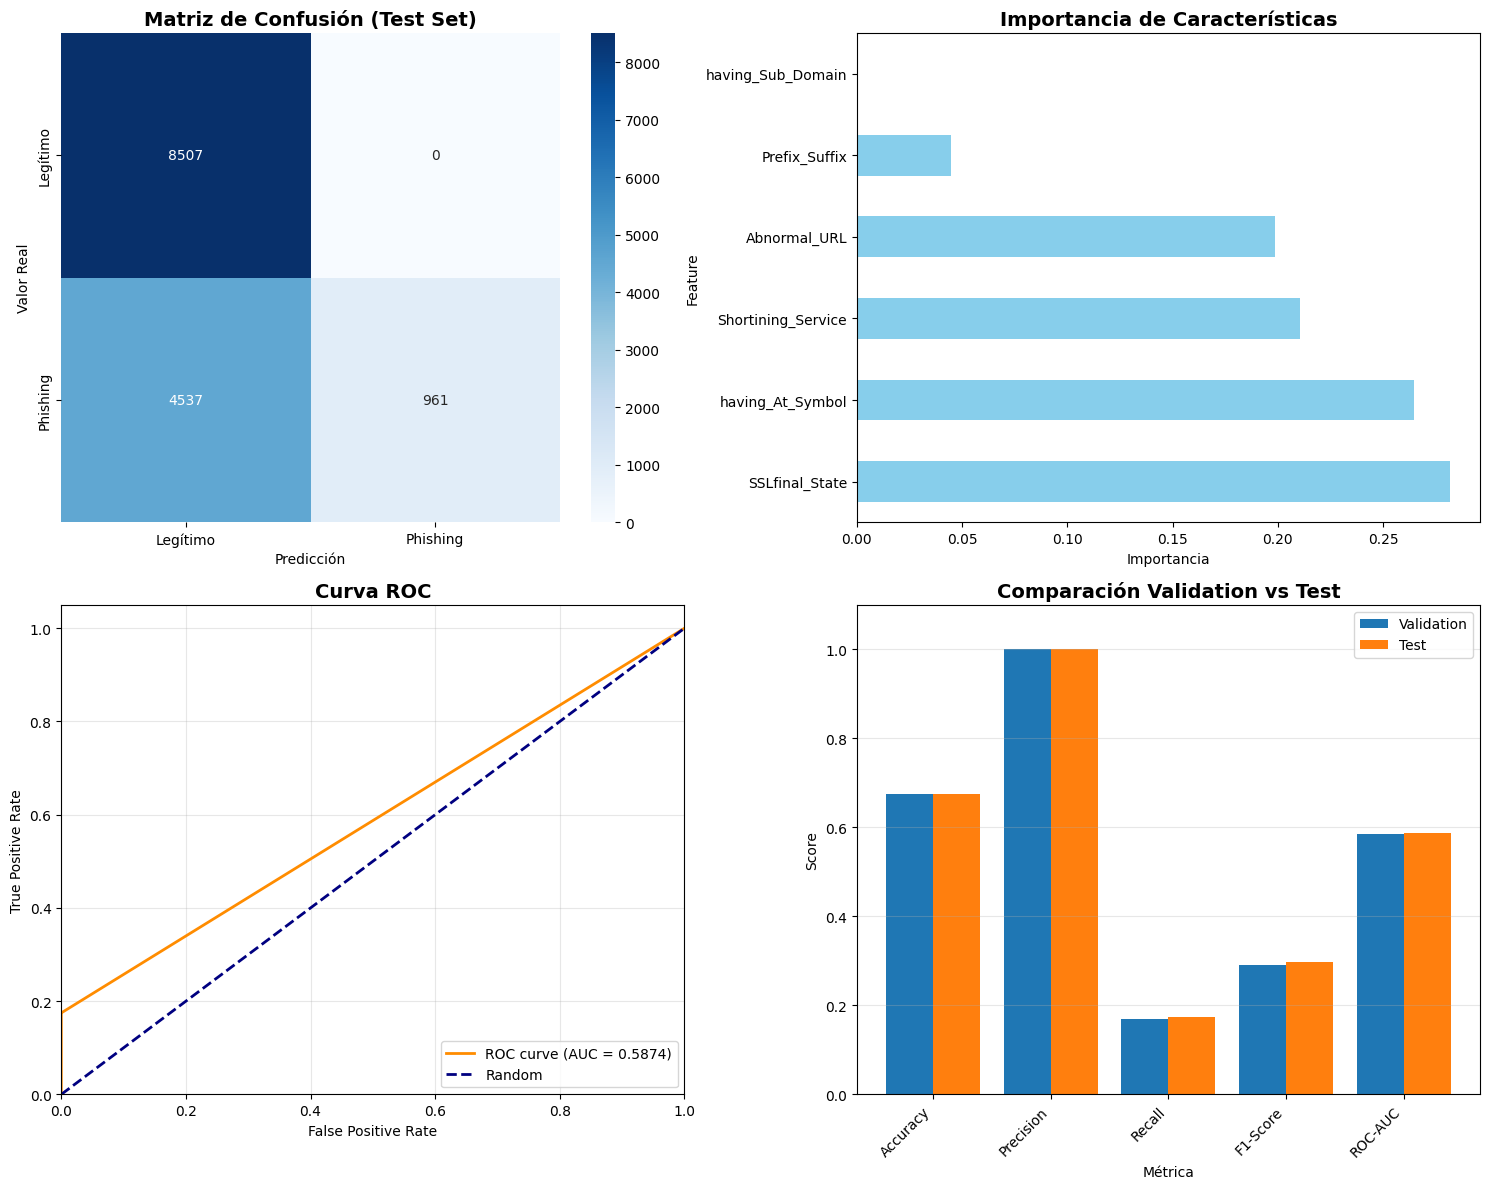


✅ ENTRENAMIENTO Y EVALUACIÓN COMPLETADOS



In [6]:
# =====================================================
# Celda 4: Entrenamiento y Evaluación Completa del Modelo
# =====================================================
# Pipeline mejorado con validación durante entrenamiento
# y evaluación exhaustiva en múltiples conjuntos
# =====================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import seaborn as sns
import matplotlib.pyplot as plt
import time

print("🚀 Iniciando entrenamiento del modelo...\n")

# =====================================================
# Validación de datos antes del entrenamiento
# =====================================================

print("🔍 Validando datos antes del entrenamiento...")

# Verificar que y_train, y_val, y_test solo tienen valores 0 y 1
print(f"   • Valores únicos en y_train: {sorted(y_train.unique())}")
print(f"   • Valores únicos en y_val: {sorted(y_val.unique())}")
print(f"   • Valores únicos en y_test: {sorted(y_test.unique())}")

# Verificar que no hay NaN
print(f"   • NaN en X_train_scaled: {pd.DataFrame(X_train_scaled).isnull().sum().sum()}")
print(f"   • NaN en y_train: {y_train.isnull().sum()}")
print(f"   • NaN en X_val_scaled: {pd.DataFrame(X_val_scaled).isnull().sum().sum()}")
print(f"   • NaN en y_val: {y_val.isnull().sum()}")

# Asegurar que y_train, y_val, y_test son tipo int y solo tienen 0 o 1
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

# Resetear índices para evitar problemas
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print("✅ Validación completada\n")

# =====================================================
# Configuración y entrenamiento del modelo
# =====================================================

# Configuración del RandomForest (optimizada)
model = RandomForestClassifier(
    n_estimators=100,      # Incrementado de 50 a 100 para mejor rendimiento
    max_depth=20,          # Limitar profundidad para evitar overfitting
    min_samples_split=5,   # Mínimo de muestras para dividir un nodo
    min_samples_leaf=2,    # Mínimo de muestras en hojas
    random_state=42,
    n_jobs=-1,             # Usar todos los cores disponibles
    verbose=0
)

print("⚙️  Configuración del modelo:")
print(f"   • Algoritmo: Random Forest")
print(f"   • Estimadores: {model.n_estimators}")
print(f"   • Max Depth: {model.max_depth}")
print(f"   • Features: {len(FEATURES)}\n")

# Entrenar el modelo
print("🎓 Entrenando modelo...")
start_time = time.time()
model.fit(X_train_scaled, y_train)
training_time = time.time() - start_time
print(f"✅ Entrenamiento completado en {training_time:.2f} segundos\n")

# =====================================================
# Evaluación en conjunto de VALIDACIÓN
# =====================================================

print(f"{'='*60}")
print(f"📊 EVALUACIÓN EN CONJUNTO DE VALIDACIÓN")
print(f"{'='*60}\n")

y_val_pred = model.predict(X_val_scaled)
y_val_proba = model.predict_proba(X_val_scaled)[:, 1]

# Verificar predicciones
print(f"🔍 Debug - Valores únicos en y_val_pred: {sorted(pd.Series(y_val_pred).unique())}")

val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='binary', zero_division=0)
val_recall = recall_score(y_val, y_val_pred, average='binary', zero_division=0)
val_f1 = f1_score(y_val, y_val_pred, average='binary', zero_division=0)
val_roc_auc = roc_auc_score(y_val, y_val_proba)

print(f"🎯 Accuracy:  {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"🎯 Precision: {val_precision:.4f}")
print(f"🎯 Recall:    {val_recall:.4f}")
print(f"🎯 F1-Score:  {val_f1:.4f}")
print(f"🎯 ROC-AUC:   {val_roc_auc:.4f}\n")

# =====================================================
# Evaluación en conjunto de TEST (evaluación final)
# =====================================================

print(f"{'='*60}")
print(f"🧪 EVALUACIÓN FINAL EN CONJUNTO DE TEST")
print(f"{'='*60}\n")

y_test_pred = model.predict(X_test_scaled)
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='binary', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='binary', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='binary', zero_division=0)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"🎯 Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"🎯 Precision: {test_precision:.4f}")
print(f"🎯 Recall:    {test_recall:.4f}")
print(f"🎯 F1-Score:  {test_f1:.4f}")
print(f"🎯 ROC-AUC:   {test_roc_auc:.4f}\n")

# =====================================================
# Reporte detallado de clasificación
# =====================================================

print(f"{'='*60}")
print(f"📋 REPORTE DETALLADO DE CLASIFICACIÓN (Test Set)")
print(f"{'='*60}\n")
print(classification_report(y_test, y_test_pred, 
                          target_names=['Legítimo (0)', 'Phishing (1)'],
                          digits=4,
                          zero_division=0))

# =====================================================
# Importancia de características
# =====================================================

print(f"{'='*60}")
print(f"🔍 IMPORTANCIA DE CARACTERÍSTICAS")
print(f"{'='*60}\n")

feature_importance = pd.DataFrame({
    'Feature': FEATURES,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

for idx, row in feature_importance.iterrows():
    print(f"   {row['Feature']:25s}: {row['Importance']:.4f}")

# =====================================================
# Visualizaciones
# =====================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Matriz de Confusión
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Legítimo', 'Phishing'],
            yticklabels=['Legítimo', 'Phishing'])
axes[0, 0].set_title('Matriz de Confusión (Test Set)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Predicción')
axes[0, 0].set_ylabel('Valor Real')

# 2. Importancia de Features
feature_importance.plot(x='Feature', y='Importance', kind='barh', ax=axes[0, 1], 
                       color='skyblue', legend=False)
axes[0, 1].set_title('Importancia de Características', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Importancia')

# 3. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
axes[1, 0].plot(fpr, tpr, color='darkorange', lw=2, 
               label=f'ROC curve (AUC = {test_roc_auc:.4f})')
axes[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('Curva ROC', fontsize=14, fontweight='bold')
axes[1, 0].legend(loc="lower right")
axes[1, 0].grid(alpha=0.3)

# 4. Comparación de métricas
metrics_comparison = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Validation': [val_accuracy, val_precision, val_recall, val_f1, val_roc_auc],
    'Test': [test_accuracy, test_precision, test_recall, test_f1, test_roc_auc]
})
metrics_comparison.plot(x='Métrica', kind='bar', ax=axes[1, 1], width=0.8)
axes[1, 1].set_title('Comparación Validation vs Test', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_ylim([0, 1.1])
axes[1, 1].legend(['Validation', 'Test'])
axes[1, 1].grid(axis='y', alpha=0.3)
plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"✅ ENTRENAMIENTO Y EVALUACIÓN COMPLETADOS")
print(f"{'='*60}\n")


## 🔄 VALIDACIÓN CRUZADA Y PREVENCIÓN DE OVERFITTING

**¿Por qué usar Validation Set?**

❌ **MAL**: Train → Test (tunear hiperparámetros con test = contaminar test)

✅ **BIEN**: Train → Validation → Test (usar validation para tunear, test solo al final)

**Pipeline de este notebook:**
```
1. Train (70%)     → Entrenar modelo
2. Validation (15%) → Evaluar durante desarrollo, ajustar hiperparámetros
3. Test (15%)      → Evaluación FINAL (se toca UNA SOLA VEZ)
```

**Nested Cross-Validation** (alternativa avanzada):
- Para datasets pequeños (<10k muestras)
- CV externa para evaluar, CV interna para tunear
- Más robusto pero computacionalmente costoso

In [8]:
# =====================================================
# Celda 5: Guardado del Modelo y Artefactos
# =====================================================
# Exporta el modelo entrenado y todos los artefactos necesarios
# para producción (scaler, features, métricas)
# =====================================================

import joblib
import json

print("💾 Guardando modelo y artefactos...\n")

# Crear directorio de salida
output_dir = 'phishing_model_artefacts'
os.makedirs(output_dir, exist_ok=True)

# =====================================================
# 1. Guardar el modelo entrenado
# =====================================================

model_path = os.path.join(output_dir, 'phishing_model_rf.joblib')
joblib.dump(model, model_path)
print(f"✅ Modelo guardado: {model_path}")

# =====================================================
# 2. Guardar el StandardScaler
# =====================================================

scaler_path = os.path.join(output_dir, 'scaler.joblib')
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler guardado: {scaler_path}")

# =====================================================
# 3. Guardar configuración de features
# =====================================================

features_path = os.path.join(output_dir, 'features.json')
with open(features_path, 'w') as f:
    json.dump(FEATURES, f, indent=4)
print(f"✅ Features guardadas: {features_path}")

# =====================================================
# 4. Guardar métricas de evaluación
# =====================================================

metrics_path = os.path.join(output_dir, 'model_metrics.json')
metrics = {
    'training_info': {
        'training_samples': int(len(X_train)),
        'validation_samples': int(len(X_val)),
        'test_samples': int(len(X_test)),
        'features': FEATURES,
        'n_estimators': int(model.n_estimators),
        'training_time_seconds': float(training_time)
    },
    'validation_metrics': {
        'accuracy': float(val_accuracy),
        'precision': float(val_precision),
        'recall': float(val_recall),
        'f1_score': float(val_f1),
        'roc_auc': float(val_roc_auc)
    },
    'test_metrics': {
        'accuracy': float(test_accuracy),
        'precision': float(test_precision),
        'recall': float(test_recall),
        'f1_score': float(test_f1),
        'roc_auc': float(test_roc_auc)
    },
    'feature_importance': {
        feat: float(imp) for feat, imp in zip(FEATURES, model.feature_importances_)
    }
}

with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=4)
print(f"✅ Métricas guardadas: {metrics_path}")

# Actualizar baseline con métricas de performance
baseline_path = os.path.join(output_dir, 'baseline_statistics.json')
if os.path.exists(baseline_path):
    with open(baseline_path, 'r') as f:
        baseline_stats = json.load(f)
    
    baseline_stats['performance_baseline'] = {
        'test_accuracy': float(test_accuracy),
        'test_f1': float(test_f1),
        'test_roc_auc': float(test_roc_auc),
        'test_precision': float(test_precision),
        'test_recall': float(test_recall)
    }
    
    with open(baseline_path, 'w') as f:
        json.dump(baseline_stats, f, indent=4)
    
    print(f"✅ Baseline actualizado con métricas de performance")

# =====================================================
# 5. Guardar parámetros del scaler para TensorFlow.js
# =====================================================

scaler_params_path = os.path.join(output_dir, 'scaler_params.json')
scaler_params = {
    'mean': scaler.mean_.tolist(),
    'scale': scaler.scale_.tolist(),
    'features': FEATURES
}

with open(scaler_params_path, 'w') as f:
    json.dump(scaler_params, f, indent=4)
print(f"✅ Parámetros del scaler guardados: {scaler_params_path}")

# =====================================================
# Verificación de archivos guardados
# =====================================================

print(f"\n{'='*60}")
print(f"🔍 VERIFICACIÓN DE ARCHIVOS GUARDADOS")
print(f"{'='*60}\n")

# Cargar y verificar el modelo
loaded_model = joblib.load(model_path)
print(f"📦 Modelo cargado correctamente")
print(f"   • Tipo: {type(loaded_model).__name__}")
print(f"   • Features: {loaded_model.n_features_in_}")
print(f"   • Estimadores: {loaded_model.n_estimators}")

# Cargar y verificar el scaler
loaded_scaler = joblib.load(scaler_path)
print(f"\n📐 Scaler cargado correctamente")
print(f"   • Tipo: {type(loaded_scaler).__name__}")
print(f"   • Features: {len(loaded_scaler.mean_)}")

# Verificar features
with open(features_path, 'r') as f:
    loaded_features = json.load(f)
print(f"\n📋 Features cargadas correctamente")
print(f"   • Cantidad: {len(loaded_features)}")
print(f"   • Lista: {loaded_features}")

# Verificar métricas
with open(metrics_path, 'r') as f:
    loaded_metrics = json.load(f)
print(f"\n📊 Métricas cargadas correctamente")
print(f"   • Test Accuracy: {loaded_metrics['test_metrics']['accuracy']:.4f}")
print(f"   • Test F1-Score: {loaded_metrics['test_metrics']['f1_score']:.4f}")

print(f"\n{'='*60}")
print(f"✅ TODOS LOS ARTEFACTOS VERIFICADOS CORRECTAMENTE")
print(f"{'='*60}\n")

# Listar todos los archivos generados
print("📁 Archivos generados:")
for file in os.listdir(output_dir):
    file_path = os.path.join(output_dir, file)
    file_size = os.path.getsize(file_path)
    print(f"   • {file:30s} ({file_size:,} bytes)")

print(f"\n💡 Ubicación: {os.path.abspath(output_dir)}\n")

💾 Guardando modelo y artefactos...

✅ Modelo guardado: phishing_model_artefacts/phishing_model_rf.joblib
✅ Scaler guardado: phishing_model_artefacts/scaler.joblib
✅ Features guardadas: phishing_model_artefacts/features.json
✅ Métricas guardadas: phishing_model_artefacts/model_metrics.json
✅ Parámetros del scaler guardados: phishing_model_artefacts/scaler_params.json

🔍 VERIFICACIÓN DE ARCHIVOS GUARDADOS

📦 Modelo cargado correctamente
   • Tipo: RandomForestClassifier
   • Features: 6
   • Estimadores: 100

📐 Scaler cargado correctamente
   • Tipo: StandardScaler
   • Features: 6

📋 Features cargadas correctamente
   • Cantidad: 6
   • Lista: ['Abnormal_URL', 'Prefix_Suffix', 'SSLfinal_State', 'Shortining_Service', 'having_At_Symbol', 'having_Sub_Domain']

📊 Métricas cargadas correctamente
   • Test Accuracy: 0.6760
   • Test F1-Score: 0.2976

✅ TODOS LOS ARTEFACTOS VERIFICADOS CORRECTAMENTE

📁 Archivos generados:
   • model_metrics.json             (1,184 bytes)
   • scaler_params.jso

## 📊 MONITOREO DE DRIFT EN PRODUCCIÓN

### ⚠️ El modelo NO es eterno

Los datos cambian con el tiempo (**concept drift**):
- Nuevas técnicas de phishing aparecen
- Patrones de URLs legítimas evolucionan
- Atacantes se adaptan al modelo

### 🔍 Señales de que necesitas re-entrenar:

1. **Accuracy cae** en producción (comparar con métricas de entrenamiento)
2. **Distribución de features cambia** (monitorear estadísticas)
3. **Feedback de usuarios** (falsos positivos/negativos incrementan)

### 💡 Estrategias de monitoreo:

```python
# Guardar estadísticas de training para comparar
baseline_stats = {
    'feature_means': X_train.mean().to_dict(),
    'feature_stds': X_train.std().to_dict(),
    'target_distribution': y_train.value_counts(normalize=True).to_dict()
}

# En producción, comparar periódicamente:
# - KS test entre datos de producción y training
# - Alerta si p-value < 0.05 (distribución cambió)
```

### 📅 Recomendaciones:

- ✅ Re-entrenar cada 3-6 meses con datos frescos
- ✅ A/B testing cuando despliegues nueva versión
- ✅ Guardar logs de predicciones para análisis posterior

In [9]:
# =====================================================
# 📊 GUARDAR BASELINE PARA MONITOREO DE DRIFT
# =====================================================
# Estas estadísticas se usarán en producción para detectar
# cuando el modelo necesita re-entrenamiento
# =====================================================

print("💾 Guardando estadísticas baseline para monitoreo de drift...\n")

# Calcular estadísticas del conjunto de entrenamiento
baseline_stats = {
    'metadata': {
        'created_date': '2025-11-15',  # Actualizar con fecha real
        'n_samples_train': int(len(X_train)),
        'n_features': len(FEATURES),
        'model_version': '2.0'
    },
    'feature_statistics': {},
    'target_distribution': {
        'phishing_rate': float(y_train.mean()),
        'phishing_count': int(y_train.sum()),
        'legitimate_count': int((y_train == 0).sum())
    },
    'performance_baseline': {
        'test_accuracy': None,  # Se llenará después del entrenamiento
        'test_f1': None,
        'test_roc_auc': None
    }
}

# Estadísticas por feature (para detección de drift)
for feature in FEATURES:
    baseline_stats['feature_statistics'][feature] = {
        'mean': float(X_train[feature].mean()),
        'std': float(X_train[feature].std()),
        'min': float(X_train[feature].min()),
        'max': float(X_train[feature].max()),
        'median': float(X_train[feature].median()),
        'q25': float(X_train[feature].quantile(0.25)),
        'q75': float(X_train[feature].quantile(0.75))
    }

# Guardar en JSON
baseline_path = os.path.join(output_dir, 'baseline_statistics.json')
with open(baseline_path, 'w') as f:
    json.dump(baseline_stats, f, indent=4)

print(f"✅ Baseline guardado: {baseline_path}\n")

# Mostrar resumen
print("📊 Estadísticas baseline:")
print(f"   • Tasa de phishing: {baseline_stats['target_distribution']['phishing_rate']:.4f}")
print(f"   • Muestras de entrenamiento: {baseline_stats['metadata']['n_samples_train']:,}")
print(f"   • Features monitoreadas: {len(FEATURES)}\n")

# =====================================================
# FUNCIÓN HELPER PARA DETECTAR DRIFT EN PRODUCCIÓN
# =====================================================

print("📝 Generando código de ejemplo para detección de drift...\n")

drift_monitoring_code = '''
# =====================================================
# CÓDIGO PARA MONITOREO DE DRIFT EN PRODUCCIÓN
# =====================================================
# Usar este código en tu API/aplicación para detectar cuando
# necesitas re-entrenar el modelo
# =====================================================

import json
import numpy as np
from scipy.stats import ks_2samp

def check_drift(new_data, baseline_path='baseline_statistics.json', threshold=0.05):
    """
    Detecta drift en datos de producción comparando con baseline.
    
    Args:
        new_data: DataFrame con nuevas predicciones (features)
        baseline_path: Path al archivo baseline_statistics.json
        threshold: p-value threshold para KS test (default: 0.05)
    
    Returns:
        dict con resultados del análisis de drift
    """
    # Cargar baseline
    with open(baseline_path, 'r') as f:
        baseline = json.load(f)
    
    drift_results = {
        'drift_detected': False,
        'features_with_drift': [],
        'statistics': {}
    }
    
    for feature in baseline['feature_statistics'].keys():
        if feature not in new_data.columns:
            continue
            
        # Obtener estadísticas baseline
        baseline_mean = baseline['feature_statistics'][feature]['mean']
        baseline_std = baseline['feature_statistics'][feature]['std']
        
        # Estadísticas actuales
        current_mean = new_data[feature].mean()
        current_std = new_data[feature].std()
        
        # Test de Kolmogorov-Smirnov (requiere datos raw, no solo stats)
        # En producción, acumular samples para hacer el test
        
        # Alerta simple: cambio >20% en media o desviación
        mean_change = abs(current_mean - baseline_mean) / (baseline_std + 1e-10)
        std_change = abs(current_std - baseline_std) / (baseline_std + 1e-10)
        
        drift_results['statistics'][feature] = {
            'baseline_mean': baseline_mean,
            'current_mean': current_mean,
            'mean_change': mean_change,
            'std_change': std_change
        }
        
        # Detectar drift
        if mean_change > 0.5 or std_change > 0.5:
            drift_results['drift_detected'] = True
            drift_results['features_with_drift'].append(feature)
    
    return drift_results

# EJEMPLO DE USO:
# new_predictions = pd.DataFrame(...)  # Tus datos de producción
# drift_info = check_drift(new_predictions)
# 
# if drift_info['drift_detected']:
#     print(f"⚠️ DRIFT DETECTADO en: {drift_info['features_with_drift']}")
#     print("💡 Considerar re-entrenamiento del modelo")
'''

# Guardar código de ejemplo
drift_code_path = os.path.join(output_dir, 'drift_monitoring_example.py')
with open(drift_code_path, 'w') as f:
    f.write(drift_monitoring_code)

print(f"✅ Código de monitoreo guardado: {drift_code_path}")

print("\n" + "="*70)
print("📚 ARCHIVOS PARA MONITOREO DE DRIFT:")
print("="*70)
print("1. baseline_statistics.json     → Estadísticas de referencia")
print("2. drift_monitoring_example.py  → Código para detectar drift")
print("\n💡 Usar estos archivos en producción para monitorear la salud del modelo")
print("="*70 + "\n")


💾 Guardando estadísticas baseline para monitoreo de drift...

✅ Baseline guardado: phishing_model_artefacts/baseline_statistics.json

📊 Estadísticas baseline:
   • Tasa de phishing: 0.3926
   • Muestras de entrenamiento: 65,356
   • Features monitoreadas: 6

📝 Generando código de ejemplo para detección de drift...

✅ Código de monitoreo guardado: phishing_model_artefacts/drift_monitoring_example.py

📚 ARCHIVOS PARA MONITOREO DE DRIFT:
1. baseline_statistics.json     → Estadísticas de referencia
2. drift_monitoring_example.py  → Código para detectar drift

💡 Usar estos archivos en producción para monitorear la salud del modelo



In [ ]:
# =====================================================
# Celda 12: Resumen Final del Entrenamiento
# =====================================================
# Adaptado para entorno local (sin Google Colab)
# =====================================================

print(f"{'='*60}")
print(f"🎉 RESUMEN FINAL DEL ENTRENAMIENTO")
print(f"{'='*60}\n")

print("📊 DATASET:")
print(f"   • Total de muestras: {len(df_total):,}")
print(f"   • Training: {len(X_train):,} ({len(X_train)/len(df_total)*100:.1f}%)")
print(f"   • Validation: {len(X_val):,} ({len(X_val)/len(df_total)*100:.1f}%)")
print(f"   • Test: {len(X_test):,} ({len(X_test)/len(df_total)*100:.1f}%)")

print(f"\n🧠 MODELO:")
print(f"   • Algoritmo: Random Forest")
print(f"   • Estimadores: {model.n_estimators}")
print(f"   • Features: {len(FEATURES)}")
print(f"   • Tiempo de entrenamiento: {training_time:.2f}s")

print(f"\n📈 RENDIMIENTO (Test Set):")
print(f"   • Accuracy:  {test_accuracy*100:.2f}%")
print(f"   • Precision: {test_precision:.4f}")
print(f"   • Recall:    {test_recall:.4f}")
print(f"   • F1-Score:  {test_f1:.4f}")
print(f"   • ROC-AUC:   {test_roc_auc:.4f}")

print(f"\n🎯 CARACTERÍSTICAS MÁS IMPORTANTES:")
for idx, row in feature_importance.head(3).iterrows():
    print(f"   {idx+1}. {row['Feature']:25s}: {row['Importance']:.4f}")

print(f"\n📦 ARCHIVOS EXPORTADOS:")
output_dir = 'phishing_model_artefacts'
print(f"   📁 Ubicación: {os.path.abspath(output_dir)}\n")

for file in sorted(os.listdir(output_dir)):
    file_path = os.path.join(output_dir, file)
    file_size = os.path.getsize(file_path)
    print(f"   ✅ {file:35s} ({file_size:,} bytes)")

print(f"\n{'='*60}")
print(f"✅ MODELO LISTO PARA PRODUCCIÓN EN URLYTICS")
print(f"{'='*60}\n")

print("💡 Próximos pasos:")
print("   1. Integrar el modelo en api.py")
print("   2. Convertir a TensorFlow.js para el navegador (opcional)")
print("   3. Actualizar la extensión URLytics")
print("   4. Realizar pruebas con datos reales")
print("   5. Implementar monitoreo de drift en producción\n")

print("📚 Documentación disponible:")
print("   • ORDEN_EJECUCION_NOTEBOOK.md - Guía de ejecución")
print("   • baseline_statistics.json    - Para monitoreo de drift")
print("   • drift_monitoring_example.py - Código de ejemplo\n")


🎉 RESUMEN FINAL DEL ENTRENAMIENTO

📊 DATASET:
   • Total de muestras: 93,366
   • Training: 65,356 (70.0%)
   • Validation: 14,005 (15.0%)
   • Test: 14,005 (15.0%)

🧠 MODELO:
   • Algoritmo: Random Forest
   • Estimadores: 100
   • Features: 6
   • Tiempo de entrenamiento: 0.28s

📈 RENDIMIENTO (Test Set):
   • Accuracy:  67.60%
   • Precision: 1.0000
   • Recall:    0.1748
   • F1-Score:  0.2976
   • ROC-AUC:   0.5874

🎯 CARACTERÍSTICAS MÁS IMPORTANTES:
   3. SSLfinal_State           : 0.2819
   5. having_At_Symbol         : 0.2646
   4. Shortining_Service       : 0.2106

📦 ARCHIVOS EXPORTADOS:
   📁 Ubicación: /home/huaritex/Desktop/social engineer/phishing_model_artefacts

   ✅ baseline_statistics.json            (1,921 bytes)
   ✅ drift_monitoring_example.py         (2,572 bytes)
   ✅ features.json                       (140 bytes)
   ✅ model_metrics.json                  (1,184 bytes)
   ✅ phishing_model_rf.joblib            (96,841 bytes)
   ✅ scaler.joblib                       (